<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/main/STEP_4A_PIDNET_weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [ ]:
!pip install torchmetrics
!pip install fvcore

In [ ]:
from google.colab import drive
import os

!git clone -b angelo_albumentations --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

fatal: destination path 'AML_2025_project4' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Skipping extraction for the dataset, already extracted.
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [ ]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

IGNORE_INDEX = -1

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 21

GAMMA = 0.1

LR = 0.00053

LR_D = 2.7e-6

LAMBDA_ADV_TARGET = 0.0074

LAMBDA_SEG = 0.45

P = 0.5 # augmentation probability

LOSS_TYPE = "ohem" # "ohem", "ce"

TYPE_WEIGHT = "median-frequency" # median-frequency | inverse | log

IGNORE_INDEX = -1

WEIGHT_DECAY = 0

MOMENTUM = 0

PLATEAU = True

# Define and instantiate

### Define PIDnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

## Define Discriminator
Used for the adversarial approach

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class FCDiscriminator(nn.Module):

	def __init__(self, num_classes, ndf = 64):
		super(FCDiscriminator, self).__init__()

		self.conv1 = nn.Conv2d(num_classes, ndf, kernel_size=4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1)
		self.conv4 = nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1)
		self.classifier = nn.Conv2d(ndf*8, 1, kernel_size=4, stride=2, padding=1)

		self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)


	def forward(self, x):
		x = self.conv1(x)
		x = self.leaky_relu(x)
		x = self.conv2(x)
		x = self.leaky_relu(x)
		x = self.conv3(x)
		x = self.leaky_relu(x)
		x = self.conv4(x)
		x = self.leaky_relu(x)
		x = self.classifier(x)

		return x

# Dataset & dataloader

## Dataset definition

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, target=False, augmentation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.augmentation = augmentation
        self.target = target

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


        if self.augmentation:
          transformed = self.augmentation(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]


        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        # if the dataset is a target dataset, does not return the mask
        if self.target == True:
          return image, boundaries_tensor
        return image, mask, boundaries_tensor

In [ ]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2

resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])

# the best augmentation from previous step is chosen
alb_aug0 = A.HorizontalFlip(p=P)
alb_aug1 = A.GaussianBlur(p=P, sigma_limit=(0.5, 3.0))
alb_aug4 = A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=P)

augment = A.Compose([alb_aug4, alb_aug0, alb_aug1])

## Dataset instantiation

In [ ]:
# Create dataset objects
val_ratio = 0.2
generator = torch.Generator().manual_seed(42)

#---------------------- VALIDATION DATASET ----------------------
train_and_val_dataset_urban = SegmentationDataset(
    TRAINING_PATH_URBAN + "/images_png",
    TRAINING_PATH_URBAN + "/masks_png",
    transform=resize_transform,
    augmentation=None
)

val_size = int(len(train_and_val_dataset_urban) * val_ratio)
train_size = len(train_and_val_dataset_urban) - val_size

#without augmentation
_, val_dataset = random_split(train_and_val_dataset_urban, [train_size, val_size], generator=generator)
print(f"Validation size: {len(val_dataset)}")

#---------------------- SORUCE DATASET----------------------
train_and_val_dataset_urban_aug = SegmentationDataset(
    TRAINING_PATH_URBAN + "/images_png",
    TRAINING_PATH_URBAN + "/masks_png",
    transform=resize_transform,
    augmentation=augment
)

#with augmentation
source_dataset, _ = random_split(train_and_val_dataset_urban_aug, [train_size, val_size], generator=generator)
print(f"Source dataset size: {len(source_dataset)}")

#---------------------- TARGET DATASET----------------------
target_dataset = SegmentationDataset(TRAINING_PATH_RURAL + "/images_png", TRAINING_PATH_RURAL + "/masks_png",
                                    transform=resize_transform, target=True, augmentation=augment)
print(f"Target dataset size: {len(target_dataset)}")


#---------------------- TEST DATASET----------------------
test_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)
print(f"Test dataset size: {len(test_dataset)}")

Validation size: 231
Source dataset size: 925
Target dataset size: 1366
Test dataset size: 992


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

class_counts = torch.zeros(NUM_CLASSES)

for (images, labels, _) in tqdm(DataLoader(source_dataset, batch_size=BATCH_SIZE)):
    for c in range(NUM_CLASSES):
        class_counts[c] += torch.sum(labels == c)

class_counts = class_counts.numpy()
total_pixels = np.sum(class_counts)
frequencies = class_counts / total_pixels

if TYPE_WEIGHT == "inverse":
  #Inverse frequency
  class_weights = 1.0 / (frequencies + 1e-8)
elif TYPE_WEIGHT == "median-frequency":
  #Median frequency balancing
  median = np.median(frequencies)
  class_weights = median / (frequencies + 1e-8)
elif TYPE_WEIGHT == "log":
  #Log smoothing
  class_weights = 1.0 / np.log(1.02 + frequencies)


print(class_weights)

#inverse = [ 2.063954, 4.717028, 10.776062, 26.797655, 13.217381, 12.630906, 53.904175]

#median-frequency = [0.16340506, 0.37345123, 0.85315025, 2.1215937,  1.0464315,  0.9999999, 4.2676406]

#log = [ 2.4481893, 4.793011, 9.3564825, 17.942291, 10.946302, 10.575735, 26.43621]

[0.16340506, 0.37345123, 0.85315025, 2.1215937, 1.0464315, 0.9999999, 4.2676406]


<ipython-input-57-d3d8c6f7f018>:16: RuntimeWarning: invalid value encountered in divide
  frequencies = class_counts / total_pixels


## Loader instantiation

In [ ]:
# Create DataLoaders

# TRAINING DATALOADERS
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# TEST DATALOADER
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# enumerate dataloaders
source_loader_iter = enumerate(source_loader)
target_loader_iter = enumerate(target_loader)


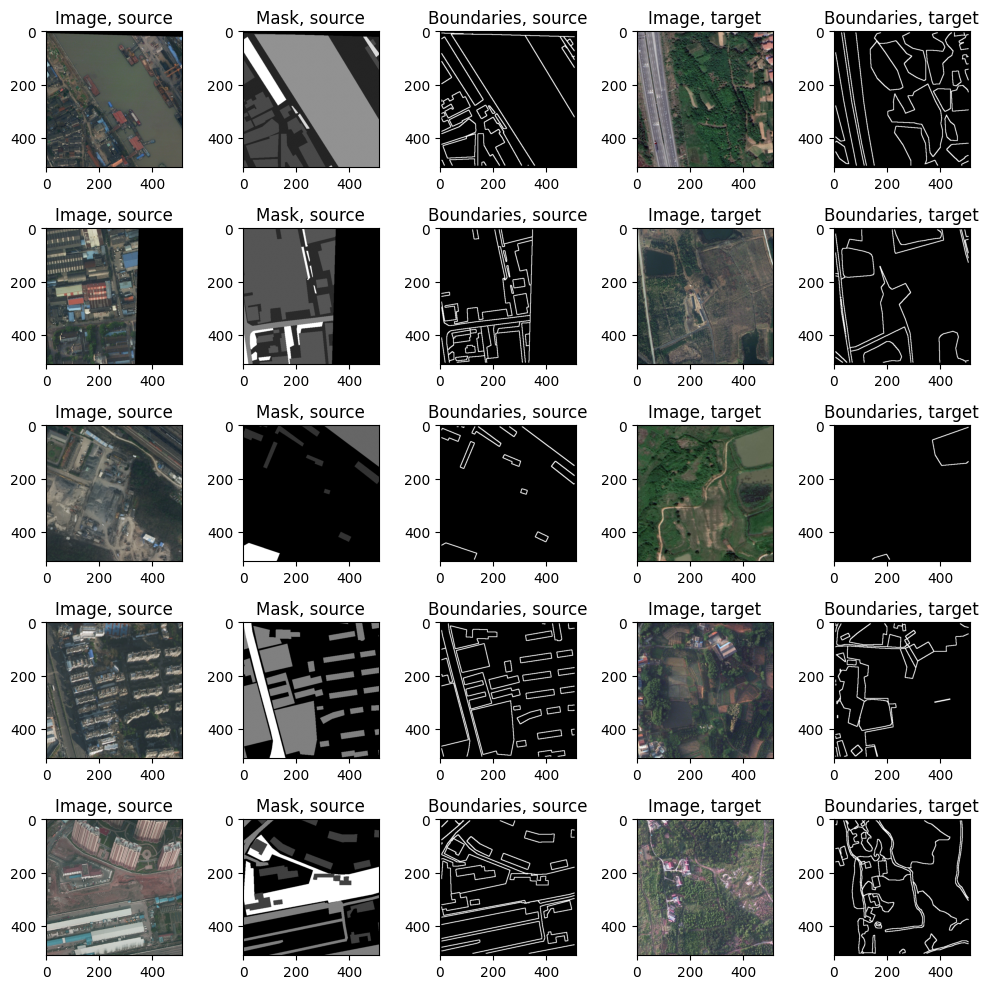

In [ ]:
from utils import show
from matplotlib import pyplot as plt

source_batch = next(iter(source_loader))  # (images, masks, boundaries)
target_batch = next(iter(target_loader))  # (images, masks, boundaries)
images_s, masks_s, boundaries_s = source_batch  # Unpack the source batch
images_t, boundaries_t = target_batch  # Unpack the target batch

fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 3 images, each with RGB, mask, and boundary

for i in range(5):  # Show first 3 images

    # VISUALIZE SOURCE SAMPLES
    # Permute the dimensions of the image tensor to (height, width, channels)
    image_s_np = images_s[i].cpu().numpy().transpose(1, 2, 0)

    axes[i, 0].imshow(image_s_np) # Display the image with the correct shape
    axes[i, 0].set_title("Image, source")

    axes[i, 1].imshow(masks_s[i].cpu().numpy(), cmap="gray")  # Show mask
    axes[i, 1].set_title("Mask, source")

    axes[i, 2].imshow(boundaries_s[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 2].set_title("Boundaries, source")

    # VISUALIZE TARGET SAMPLES
    image_t_np = images_t[i].cpu().numpy().transpose(1, 2, 0)
    axes[i, 3].imshow(image_t_np) # Display the image with the correct shape
    axes[i, 3].set_title("Image, target")

    axes[i, 4].imshow(boundaries_t[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 4].set_title("Boundaries, target")


plt.tight_layout()
plt.show()

### Instantiate model

In [ ]:
import gdown

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)

# Training Phase

## Define loss functions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, num_outputs, weight=None, balance_weights=[0.4, 1.0], sb_weights=1.0):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=IGNORE_INDEX)
        self.num_outputs = num_outputs
        self.balance_weights = balance_weights
        self.sb_weights = sb_weights

    def _forward(self, pred, target):
        return self.loss(pred, target)

    def forward(self, score, target):
        if self.num_outputs == 1:
            score = [score]

        if len(self.balance_weights) == len(score):
            return sum([w * self._forward(x, target) for (w, x) in zip(self.balance_weights, score)])
        elif len(score) == 1:
            return self.sb_weights * self._forward(score[0], target)
        else:
            raise ValueError("lengths of prediction and target are not identical!")

# OHEM cross entropy
class OhemCrossEntropy(nn.Module):
    def __init__(self, thres=0.7, min_kept=26_000, balance_weights=[0.4, 1.0], sb_weights=1.0, weight=None):
        super(OhemCrossEntropy, self).__init__()
        self.thresh = thres
        self.min_kept = max(1, min_kept)
        self.ignore_label = IGNORE_INDEX
        self.balance_weights = balance_weights
        self.sb_weights = sb_weights
        self.criterion = nn.CrossEntropyLoss(
            weight=weight,
            ignore_index=self.ignore_label,
            reduction='none'
        )

    def _ce_forward(self, score, target):
        loss = self.criterion(score, target)
        return loss

    def _ohem_forward(self, score, target, **kwargs):
        pred = F.softmax(score, dim=1)
        pixel_losses = self.criterion(score, target).contiguous().view(-1)
        mask = target.contiguous().view(-1) != self.ignore_label

        tmp_target = target.clone()
        tmp_target[tmp_target == self.ignore_label] = 0
        pred = pred.gather(1, tmp_target.unsqueeze(1))
        pred, ind = pred.contiguous().view(-1,)[mask].contiguous().sort()

        if pred.numel() == 0:
          min_value = 0  # or self.thresh, or skip
        else:
          min_value = pred[min(self.min_kept, pred.numel() - 1)]
        threshold = max(min_value, self.thresh)

        pixel_losses = pixel_losses[mask][ind]
        pixel_losses = pixel_losses[pred < threshold]
        return pixel_losses.mean()

    def forward(self, score, target):
        if not (isinstance(score, list) or isinstance(score, tuple)):
            score = [score]

        if len(self.balance_weights) == len(score):
            functions = [self._ce_forward] * \
                (len(self.balance_weights) - 1) + [self._ohem_forward]
            return sum([
                w * func(x, target)
                for (w, x, func) in zip(self.balance_weights, score, functions)
            ])

        elif len(score) == 1:
            return self.sb_weights * self._ohem_forward(score[0], target)

        else:
            raise ValueError("lengths of prediction and target are not identical!")


# Weighted Binary Cross Entropy for the edges
def weighted_bce(bd_pre, target):
    n, c, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

class BondaryLoss(nn.Module):
    def __init__(self, coeff_bce = 20.0):
        super(BondaryLoss, self).__init__()
        self.coeff_bce = coeff_bce

    def forward(self, bd_pre, bd_gt):
        bce_loss = self.coeff_bce * weighted_bce(bd_pre, bd_gt)
        loss = bce_loss

        return loss

# PIDNet Loss
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8, class_weights=None):
        super(PIDNetLoss, self).__init__()
        self.class_weights = class_weights
        if self.class_weights is not None:
            self.class_weights = torch.tensor(class_weights).cuda()
        if LOSS_TYPE == "ohem":
          self.sem_loss = OhemCrossEntropy(balance_weights=[lambda_0, lambda_2], sb_weights=lambda_3, weight = self.class_weights)
        else:
          self.sem_loss = CrossEntropyLoss(num_outputs=2, balance_weights=[lambda_0, lambda_2], sb_weights=lambda_3, weight = self.class_weights)
        self.bd_loss = BondaryLoss(coeff_bce=lambda_1)
        self.threshold = threshold

    def forward(self, pred_p, pred_main, target, boundary_head, boundary_mask):
        """
        pred_p: output branch P (B, C, H, W)
        pred_main: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """

        loss_s = self.sem_loss([pred_p, pred_main], target) # l_0 e l_2
        loss_b = self.bd_loss(boundary_head, boundary_mask.unsqueeze(1)) # l_1

        # l_3
        filler = torch.ones_like(target) * IGNORE_INDEX
        bd_label = torch.where(F.sigmoid(boundary_head[:,0,:,:])>self.threshold, target, filler)
        loss_sb = self.sem_loss([pred_main], bd_label)


        loss = loss_s + loss_b + loss_sb


        return loss


## Upscaling function

In [ ]:
import torch.nn.functional as F

def Upscaling(outputs, boundary_mask, model):
    """Upscale through bilinear interpolation -> I return the output dimensions to the original ones.
    So we go from 64 x 64 of the network to 512 x 512"""

    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)
    if model.augment:
        pred_p, pred_main, boundary_head = outputs  # P, I, D branches
    else:
        pred_p = None
        pred_main = outputs
        boundary_head = None

    return pred_p, pred_main, boundary_head

## Instantiate discriminator, optimizers and schedulers

In [ ]:
from torch.optim.lr_scheduler import LambdaLR, SequentialLR, StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_D = FCDiscriminator(num_classes=NUM_CLASSES)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=LR_D)

if PLATEAU == True:
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=GAMMA, patience=3, threshold=0.01)
else:
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

bce_loss = torch.nn.BCEWithLogitsLoss()
loss_fn = PIDNetLoss(threshold=0.8, class_weights=class_weights)

print(device)

print(len(target_loader))
print(len(source_loader))

cuda
86
58


## Train

In [ ]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

source_label = 0
target_label = 1

model.to(device)
model_D.to(device)

record_miou = None

num_classes = 7
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)

print(scheduler.get_last_lr())

for epoch in range(EPOCHS):
    loss_seg_source_raw_value = 0
    loss_adv_target_raw_value = 0
    loss_D_raw_value = 0
    total_train_samples = 0

    model.train()
    model_D.train()

    train_loader = zip(source_loader, target_loader)
    num_batches = min(len(source_loader), len(target_loader))

    pbar = tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1} [Training]")

    optimizer.zero_grad()
    optimizer_D.zero_grad()

    for i, (source_batch, target_batch) in pbar:
        # --- Train G with Source---
        for param in model_D.parameters():
            param.requires_grad = False

        X, y, boundary_mask = source_batch
        X, y, boundary_mask = X.to(device), y.to(device), boundary_mask.to(device)

        outputs = model(X)
        pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)

        loss_seg_source_raw = loss_fn(pred_p, pred_main, y, boundary_head, boundary_mask)

        if LOSS_TYPE == "ohem":
            loss_seg_source_raw = loss_seg_source_raw.mean()

        (loss_seg_source_raw * LAMBDA_SEG).backward()
        loss_seg_source_raw_value += loss_seg_source_raw.item()

        # --- Train G with Target ---
        X_target, boundary_mask_target = target_batch
        X_target, boundary_mask_target = X_target.to(device), boundary_mask_target.to(device)

        outputs_target = model(X_target)
        pred_p_target, pred_main_target, boundary_head_target = Upscaling(outputs=outputs_target, boundary_mask=boundary_mask_target, model=model)

        D_out = model_D(F.softmax(pred_main_target, dim=1))
        loss_adv_target_raw = bce_loss(D_out, torch.full_like(D_out, source_label))
        (loss_adv_target_raw * LAMBDA_ADV_TARGET).backward()
        loss_adv_target_raw_value += loss_adv_target_raw.item()

        # --- Train D ---
        for param in model_D.parameters():
            param.requires_grad = True

        D_out = model_D(F.softmax(pred_main.detach(), dim=1))
        loss_D_source = bce_loss(D_out, torch.full_like(D_out, source_label))
        loss_D_source.backward()

        D_out = model_D(F.softmax(pred_main_target.detach(), dim=1))
        loss_D_target = bce_loss(D_out, torch.full_like(D_out, target_label))
        loss_D_target.backward()

        loss_D_raw_value += (loss_D_source + loss_D_target).item()

        optimizer.step()
        optimizer_D.step()
        total_train_samples += X.size(0)

        pbar.set_postfix({
            "Loss_seg": f"{loss_seg_source_raw_value / (i+1):.4f}",
            "Loss_adv": f"{loss_adv_target_raw_value / (i+1):.4f}",
            "Loss_D": f"{loss_D_raw_value / (i+1):.4f}",
        })

    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary")
    print(f"  → Segmentation Source Loss (RAW) : {loss_seg_source_raw_value / total_train_samples:.4f}")
    print(f"  → Adversarial Target Loss (RAW)  : {loss_adv_target_raw_value / total_train_samples:.4f}")
    print(f"  → Discriminator Loss (RAW)       : {loss_D_raw_value / total_train_samples:.4f}")

    # ---------------------- VALIDATION ----------------------

    model.eval()
    val_loss = 0
    miou_classes.reset()
    total_val_samples = 0

    with torch.inference_mode():
        pbar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1} [Validation]")

        for batch, (X_val, y_val, boundary_mask) in pbar_val:
            X_val, y_val, boundary_mask = X_val.to(device), y_val.to(device), boundary_mask.to(device)

            outputs = model(X_val)
            pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)

            loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)

            if LOSS_TYPE == "ohem":
                loss = loss.mean()

            val_loss += loss.item()
            total_val_samples += X_val.size(0)

            preds = pred_main.argmax(dim=1)
            valid_mask = (y_val >= 0) & (y_val < num_classes)
            preds_flat = preds[valid_mask]
            targets_flat = y_val[valid_mask]

            miou_classes.update(preds_flat, targets_flat)

            pbar_val.set_postfix({
                "Val_Loss": f"{val_loss / (batch+1):.4f}",
                "mIoU": f"{miou_classes.compute().mean():.4f}"
            })

    avg_val_loss = val_loss / total_val_samples
    miou_per_class = miou_classes.compute()
    miou = miou_per_class.mean()

    if record_miou is None or miou > record_miou:
        best_model_path = f"/content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Modello con miou migliore salvato: {best_model_path}")
        record_miou = miou

    print(f"\n→ Validation Loss: {avg_val_loss:.4f}")
    print(f"→ Overall mIoU: {miou:.4f}")
    for i, iou in enumerate(miou_per_class):
        class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
        print(f"  → {class_name} IoU: {iou:.4f}")

    scheduler.step(miou)


[0.00053]


Epoch 1 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.70it/s, Loss_seg=10.3350, Loss_adv=0.6918, Loss_D=1.3862]


Epoch 1/20 Summary
  → Segmentation Source Loss (RAW) : 0.6480
  → Adversarial Target Loss (RAW)  : 0.0434
  → Discriminator Loss (RAW)       : 0.0869



Epoch 1 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s, Val_Loss=8.7461, mIoU=0.1796]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.5679
→ Overall mIoU: 0.1796
  → background IoU: 0.1531
  → building IoU: 0.1817
  → road IoU: 0.1627
  → water IoU: 0.2969
  → barren IoU: 0.2521
  → forest IoU: 0.1396
  → agriculture IoU: 0.0714


Epoch 2 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=5.7125, Loss_adv=0.6941, Loss_D=1.3851]


Epoch 2/20 Summary
  → Segmentation Source Loss (RAW) : 0.3582
  → Adversarial Target Loss (RAW)  : 0.0435
  → Discriminator Loss (RAW)       : 0.0869



Epoch 2 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s, Val_Loss=4.9434, mIoU=0.2395]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.3210
→ Overall mIoU: 0.2395
  → background IoU: 0.2186
  → building IoU: 0.2942
  → road IoU: 0.2441
  → water IoU: 0.3689
  → barren IoU: 0.3217
  → forest IoU: 0.1211
  → agriculture IoU: 0.1078


Epoch 3 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=4.4334, Loss_adv=0.6902, Loss_D=1.3820]


Epoch 3/20 Summary
  → Segmentation Source Loss (RAW) : 0.2780
  → Adversarial Target Loss (RAW)  : 0.0433
  → Discriminator Loss (RAW)       : 0.0867



Epoch 3 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s, Val_Loss=4.2697, mIoU=0.2618]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2773
→ Overall mIoU: 0.2618
  → background IoU: 0.1980
  → building IoU: 0.3062
  → road IoU: 0.2624
  → water IoU: 0.3847
  → barren IoU: 0.3423
  → forest IoU: 0.2079
  → agriculture IoU: 0.1311


Epoch 4 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=4.0699, Loss_adv=0.6952, Loss_D=1.3755]


Epoch 4/20 Summary
  → Segmentation Source Loss (RAW) : 0.2552
  → Adversarial Target Loss (RAW)  : 0.0436
  → Discriminator Loss (RAW)       : 0.0862



Epoch 4 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s, Val_Loss=4.0249, mIoU=0.2989]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2614
→ Overall mIoU: 0.2989
  → background IoU: 0.2115
  → building IoU: 0.3379
  → road IoU: 0.2897
  → water IoU: 0.4818
  → barren IoU: 0.3192
  → forest IoU: 0.2518
  → agriculture IoU: 0.2002


Epoch 5 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=3.8613, Loss_adv=0.7214, Loss_D=1.3772]


Epoch 5/20 Summary
  → Segmentation Source Loss (RAW) : 0.2421
  → Adversarial Target Loss (RAW)  : 0.0452
  → Discriminator Loss (RAW)       : 0.0864



Epoch 5 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s, Val_Loss=3.9636, mIoU=0.2871]


→ Validation Loss: 0.2574
→ Overall mIoU: 0.2871
  → background IoU: 0.1941
  → building IoU: 0.3420
  → road IoU: 0.2850
  → water IoU: 0.3714
  → barren IoU: 0.3635
  → forest IoU: 0.2734
  → agriculture IoU: 0.1802



Epoch 6 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=3.7683, Loss_adv=0.6945, Loss_D=1.3764]


Epoch 6/20 Summary
  → Segmentation Source Loss (RAW) : 0.2363
  → Adversarial Target Loss (RAW)  : 0.0435
  → Discriminator Loss (RAW)       : 0.0863



Epoch 6 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s, Val_Loss=3.7298, mIoU=0.3227]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2422
→ Overall mIoU: 0.3227
  → background IoU: 0.2381
  → building IoU: 0.3535
  → road IoU: 0.3327
  → water IoU: 0.4690
  → barren IoU: 0.3222
  → forest IoU: 0.3038
  → agriculture IoU: 0.2398


Epoch 7 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=3.6534, Loss_adv=0.7385, Loss_D=1.3733]


Epoch 7/20 Summary
  → Segmentation Source Loss (RAW) : 0.2291
  → Adversarial Target Loss (RAW)  : 0.0463
  → Discriminator Loss (RAW)       : 0.0861



Epoch 7 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s, Val_Loss=3.7383, mIoU=0.3163]


→ Validation Loss: 0.2427
→ Overall mIoU: 0.3163
  → background IoU: 0.1711
  → building IoU: 0.3692
  → road IoU: 0.2963
  → water IoU: 0.5001
  → barren IoU: 0.3678
  → forest IoU: 0.3118
  → agriculture IoU: 0.1976



Epoch 8 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.70it/s, Loss_seg=3.6049, Loss_adv=0.6594, Loss_D=1.3691]


Epoch 8/20 Summary
  → Segmentation Source Loss (RAW) : 0.2260
  → Adversarial Target Loss (RAW)  : 0.0413
  → Discriminator Loss (RAW)       : 0.0858



Epoch 8 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s, Val_Loss=3.8048, mIoU=0.3440]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2471
→ Overall mIoU: 0.3440
  → background IoU: 0.2917
  → building IoU: 0.3471
  → road IoU: 0.3422
  → water IoU: 0.5008
  → barren IoU: 0.3445
  → forest IoU: 0.3289
  → agriculture IoU: 0.2532


Epoch 9 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=3.5771, Loss_adv=0.7422, Loss_D=1.3647]


Epoch 9/20 Summary
  → Segmentation Source Loss (RAW) : 0.2243
  → Adversarial Target Loss (RAW)  : 0.0465
  → Discriminator Loss (RAW)       : 0.0856



Epoch 9 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s, Val_Loss=3.6193, mIoU=0.3439]


→ Validation Loss: 0.2350
→ Overall mIoU: 0.3439
  → background IoU: 0.1943
  → building IoU: 0.3754
  → road IoU: 0.3346
  → water IoU: 0.5211
  → barren IoU: 0.3715
  → forest IoU: 0.3701
  → agriculture IoU: 0.2402



Epoch 10 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.70it/s, Loss_seg=3.5720, Loss_adv=0.7016, Loss_D=1.3546]


Epoch 10/20 Summary
  → Segmentation Source Loss (RAW) : 0.2240
  → Adversarial Target Loss (RAW)  : 0.0440
  → Discriminator Loss (RAW)       : 0.0849



Epoch 10 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s, Val_Loss=3.7126, mIoU=0.3453]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2411
→ Overall mIoU: 0.3453
  → background IoU: 0.2740
  → building IoU: 0.3658
  → road IoU: 0.3507
  → water IoU: 0.5006
  → barren IoU: 0.3601
  → forest IoU: 0.3528
  → agriculture IoU: 0.2129


Epoch 11 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=3.4927, Loss_adv=0.7254, Loss_D=1.3479]


Epoch 11/20 Summary
  → Segmentation Source Loss (RAW) : 0.2190
  → Adversarial Target Loss (RAW)  : 0.0455
  → Discriminator Loss (RAW)       : 0.0845



Epoch 11 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s, Val_Loss=3.5375, mIoU=0.3525]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2297
→ Overall mIoU: 0.3525
  → background IoU: 0.1676
  → building IoU: 0.3935
  → road IoU: 0.3469
  → water IoU: 0.5530
  → barren IoU: 0.3651
  → forest IoU: 0.3928
  → agriculture IoU: 0.2487


Epoch 12 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.70it/s, Loss_seg=3.4788, Loss_adv=0.7672, Loss_D=1.3586]


Epoch 12/20 Summary
  → Segmentation Source Loss (RAW) : 0.2181
  → Adversarial Target Loss (RAW)  : 0.0481
  → Discriminator Loss (RAW)       : 0.0852



Epoch 12 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s, Val_Loss=3.6323, mIoU=0.3614]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2359
→ Overall mIoU: 0.3614
  → background IoU: 0.2675
  → building IoU: 0.3867
  → road IoU: 0.3696
  → water IoU: 0.5332
  → barren IoU: 0.3642
  → forest IoU: 0.3515
  → agriculture IoU: 0.2570


Epoch 13 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.70it/s, Loss_seg=3.3773, Loss_adv=0.7689, Loss_D=1.3541]


Epoch 13/20 Summary
  → Segmentation Source Loss (RAW) : 0.2118
  → Adversarial Target Loss (RAW)  : 0.0482
  → Discriminator Loss (RAW)       : 0.0849



Epoch 13 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s, Val_Loss=3.4075, mIoU=0.3673]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2213
→ Overall mIoU: 0.3673
  → background IoU: 0.2099
  → building IoU: 0.4001
  → road IoU: 0.3645
  → water IoU: 0.5352
  → barren IoU: 0.3812
  → forest IoU: 0.4016
  → agriculture IoU: 0.2788


Epoch 14 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.70it/s, Loss_seg=3.3419, Loss_adv=0.6048, Loss_D=1.3690]


Epoch 14/20 Summary
  → Segmentation Source Loss (RAW) : 0.2095
  → Adversarial Target Loss (RAW)  : 0.0379
  → Discriminator Loss (RAW)       : 0.0858



Epoch 14 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.55it/s, Val_Loss=3.4893, mIoU=0.3617]


→ Validation Loss: 0.2266
→ Overall mIoU: 0.3617
  → background IoU: 0.1921
  → building IoU: 0.4016
  → road IoU: 0.3828
  → water IoU: 0.5687
  → barren IoU: 0.3607
  → forest IoU: 0.3726
  → agriculture IoU: 0.2530



Epoch 15 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.70it/s, Loss_seg=3.3537, Loss_adv=0.7577, Loss_D=1.3516]


Epoch 15/20 Summary
  → Segmentation Source Loss (RAW) : 0.2103
  → Adversarial Target Loss (RAW)  : 0.0475
  → Discriminator Loss (RAW)       : 0.0847



Epoch 15 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s, Val_Loss=3.4075, mIoU=0.3828]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2213
→ Overall mIoU: 0.3828
  → background IoU: 0.2172
  → building IoU: 0.3970
  → road IoU: 0.3958
  → water IoU: 0.5820
  → barren IoU: 0.3979
  → forest IoU: 0.3980
  → agriculture IoU: 0.2914


Epoch 16 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=3.3552, Loss_adv=0.7606, Loss_D=1.3382]


Epoch 16/20 Summary
  → Segmentation Source Loss (RAW) : 0.2104
  → Adversarial Target Loss (RAW)  : 0.0477
  → Discriminator Loss (RAW)       : 0.0839



Epoch 16 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s, Val_Loss=3.5125, mIoU=0.3729]


→ Validation Loss: 0.2281
→ Overall mIoU: 0.3729
  → background IoU: 0.2397
  → building IoU: 0.4036
  → road IoU: 0.3757
  → water IoU: 0.5493
  → barren IoU: 0.3841
  → forest IoU: 0.3913
  → agriculture IoU: 0.2664



Epoch 17 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=3.3244, Loss_adv=0.7620, Loss_D=1.3290]


Epoch 17/20 Summary
  → Segmentation Source Loss (RAW) : 0.2084
  → Adversarial Target Loss (RAW)  : 0.0478
  → Discriminator Loss (RAW)       : 0.0833



Epoch 17 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s, Val_Loss=3.3270, mIoU=0.4028]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4A_augmentation.pth

→ Validation Loss: 0.2160
→ Overall mIoU: 0.4028
  → background IoU: 0.2662
  → building IoU: 0.4128
  → road IoU: 0.4089
  → water IoU: 0.5956
  → barren IoU: 0.3899
  → forest IoU: 0.4238
  → agriculture IoU: 0.3224


Epoch 18 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.70it/s, Loss_seg=3.2977, Loss_adv=0.7808, Loss_D=1.3145]


Epoch 18/20 Summary
  → Segmentation Source Loss (RAW) : 0.2068
  → Adversarial Target Loss (RAW)  : 0.0490
  → Discriminator Loss (RAW)       : 0.0824



Epoch 18 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s, Val_Loss=3.5210, mIoU=0.3727]


→ Validation Loss: 0.2286
→ Overall mIoU: 0.3727
  → background IoU: 0.2094
  → building IoU: 0.4048
  → road IoU: 0.3838
  → water IoU: 0.5768
  → barren IoU: 0.3839
  → forest IoU: 0.3972
  → agriculture IoU: 0.2531



Epoch 19 [Training]: 100%|██████████| 58/58 [00:33<00:00,  1.71it/s, Loss_seg=3.3041, Loss_adv=0.8178, Loss_D=1.3164]


Epoch 19/20 Summary
  → Segmentation Source Loss (RAW) : 0.2072
  → Adversarial Target Loss (RAW)  : 0.0513
  → Discriminator Loss (RAW)       : 0.0825



Epoch 19 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s, Val_Loss=3.3099, mIoU=0.3868]


→ Validation Loss: 0.2149
→ Overall mIoU: 0.3868
  → background IoU: 0.1985
  → building IoU: 0.4156
  → road IoU: 0.4042
  → water IoU: 0.5916
  → barren IoU: 0.3712
  → forest IoU: 0.4218
  → agriculture IoU: 0.3050



Epoch 20 [Training]: 100%|██████████| 58/58 [00:34<00:00,  1.69it/s, Loss_seg=3.2808, Loss_adv=0.7931, Loss_D=1.3074]


Epoch 20/20 Summary
  → Segmentation Source Loss (RAW) : 0.2057
  → Adversarial Target Loss (RAW)  : 0.0497
  → Discriminator Loss (RAW)       : 0.0820



Epoch 20 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s, Val_Loss=3.3713, mIoU=0.3943]


→ Validation Loss: 0.2189
→ Overall mIoU: 0.3943
  → background IoU: 0.2494
  → building IoU: 0.4172
  → road IoU: 0.4081
  → water IoU: 0.5976
  → barren IoU: 0.3838
  → forest IoU: 0.4181
  → agriculture IoU: 0.2862


## Evaluation

In [ ]:
class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)

best_model_weights = torch.load(best_model_path)

try:
  model.load_state_dict(torch.load(best_model_path))
except:
  print(list(torch.load(best_model_path).keys())[:5])


model.to(device)

PIDNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

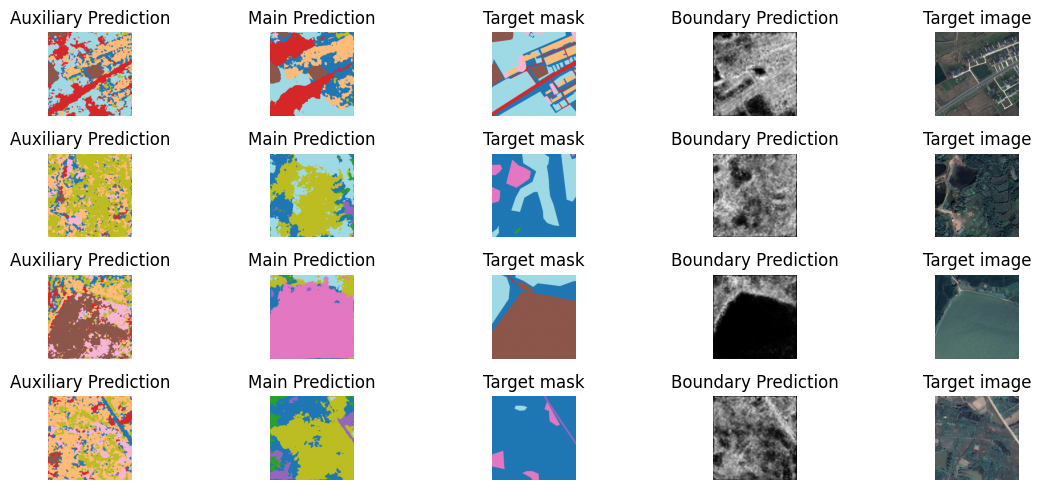

tensor(0.2263, device='cuda:0')
Validation Loss: 0.6494734527603272 | mIoU: 0.22632984817028046 | Total validation samples seen: 992
  → background IoU: 0.2778
  → building IoU: 0.1676
  → road IoU: 0.1373
  → water IoU: 0.4411
  → barren IoU: 0.0496
  → forest IoU: 0.1445
  → agriculture IoU: 0.3664


In [ ]:
# ****************************** Validation ******************************
from torchmetrics.segmentation import MeanIoU

num_classes = 7
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)
miou_overall = MeanIoU(num_classes=num_classes).to(device)

model.eval()
val_loss = 0
miou_classes.reset()
total_val_samples = 0

with torch.inference_mode():
    for batch, (X_val, y_val, boundary_mask) in enumerate(test_loader):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        outputs = model(X_val)

        #upscaling
        pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)

        if batch == 0:
          fig, axs = plt.subplots(4, 5, figsize=(12, 5))

          for j in range(4):

            axs[j, 0].imshow(pred_p[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
            axs[j, 0].set_title("Auxiliary Prediction")
            axs[j, 0].axis('off')

            axs[j, 1].imshow(pred_main[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
            axs[j, 1].set_title("Main Prediction")
            axs[j, 1].axis('off')

            axs[j, 2].imshow(y_val[j].cpu().detach().numpy(), cmap='tab20')
            axs[j, 2].set_title("Target mask")
            axs[j, 2].axis('off')

            axs[j, 3].imshow(boundary_head[j].cpu().detach().sigmoid().squeeze(0).numpy(), cmap='gray')
            axs[j, 3].set_title("Boundary Prediction")
            axs[j, 3].axis('off')

            axs[j, 4].imshow(X_val[j].cpu().detach().squeeze(0).numpy().transpose(1, 2, 0))
            axs[j, 4].set_title("Target image")
            axs[j, 4].axis('off')

          plt.tight_layout()
          plt.show()

        loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)

        if LOSS_TYPE == "ohem":
            loss = loss.mean()

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

        preds = pred_main.argmax(dim=1)
        valid_mask = (y_val >= 0) & (y_val < num_classes)
        preds_flat = preds[valid_mask]
        targets_flat = y_val[valid_mask]

        miou_classes.update(preds_flat, targets_flat)

        pbar_val.set_postfix({
            "Val_Loss": f"{val_loss / (batch+1):.4f}",
            "mIoU": f"{miou_classes.compute().mean():.4f}"
        })


avg_val_loss = val_loss / total_val_samples

miou_per_class = miou_classes.compute()
miou = miou_per_class.mean()

print(miou_per_class.mean())

print(f"Validation Loss: {avg_val_loss} | mIoU: {miou} | Total validation samples seen: {total_val_samples}")
# per class
for i, iou in enumerate(miou_per_class):
    class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
    print(f"  → {class_name} IoU: {iou:.4f}")



h: 512 | w: 512 | ph: 64 | pw: 64


FLOPs: 6.317 GFLOPs
Average inference latency is 0.014 seconds.


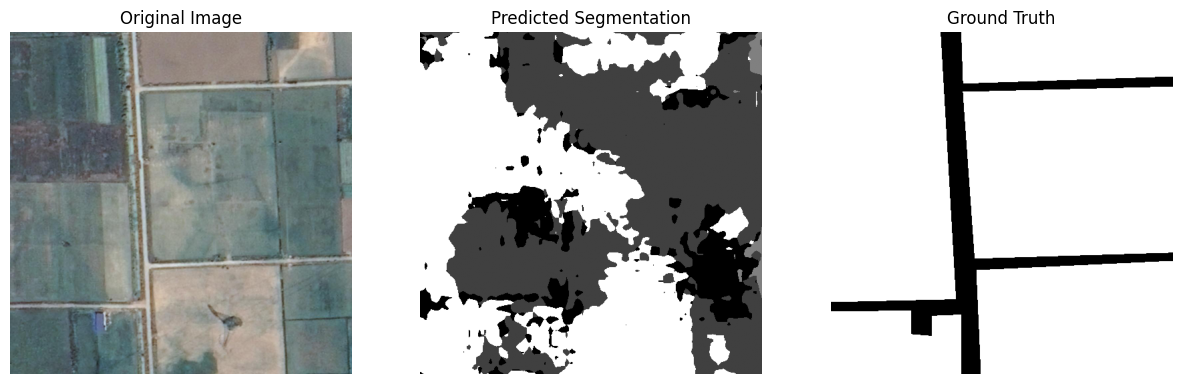

Params: 7.718 M


In [ ]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(test_dataset) - 1)
    X, y, boundary_mask = test_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    latency = end - start

    ## Upscale trough bilinear interpolation
    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    print(f"h: {h} | w: {w} | ph: {ph} | pw: {pw}")
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # Se augment=True, gestiamo i diversi output
    if model.augment:
        pred_p, pred_main, boundary_head = outputs
    else:
        pred_main = outputs
        boundary_head = None

    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(pred_main, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = pred_main.squeeze().argmax(dim=0).cpu().numpy()
    y_np = y.squeeze().cpu().numpy()
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")
